## Original content in R
Click the link here -> https://stats.oarc.ucla.edu/r/dae/logit-regression/

In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [110]:
data_origin = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

In [111]:
data = data_origin.copy()

In [112]:
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [113]:
data.shape

(400, 4)

In [114]:
data.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [115]:
data.std()

admit      0.466087
gre      115.516536
gpa        0.380567
rank       0.944460
dtype: float64

In [116]:
# Two-way contingency table of categorical outcome and predictors
contingency_table = pd.crosstab(data['admit'], data['rank'])
print(contingency_table)

rank    1   2   3   4
admit                
0      28  97  93  55
1      33  54  28  12


In [117]:
data.isna().any()

admit    False
gre      False
gpa      False
rank     False
dtype: bool

In [118]:
data['rank'] = data['rank'].astype('category')

# Define the predictor variables and the response variable
X = data[['gre', 'gpa', 'rank']]
y = data['admit']


## Why Drop Rank_1
When you encode categorical variables like rank, which has four levels, you typically use one-hot encoding, resulting in four new binary variables (e.g., rank_1, rank_2, rank_3, and rank_4). However, including all four in the model introduces multicollinearity. **In regression, multicollinearity occurs when one predictor variable can be linearly predicted from the others with a high degree of accuracy.  In this case, because the sum of all the dummy variables is always 1 (rank_1+rank_2+rank_3+rank_4=1), there is perfect multicollinearity if all four variables are included in the model. This leads to an issue known as the "dummy variable trap."** In Python, particularly when using libraries like statsmodels for logistic regression, you typically need to manually drop one category of a categorical variable when you use one-hot encoding. The library doesn't automatically handle this because it allows for flexibility in choosing the reference category based on your analysis needs. In R, when you use the glm() function to fit a generalized linear model, it automatically handles the encoding of categorical variables and drops one category as the reference by default. Specifically, R will typically use the first level of the factor as the reference category, unless specified otherwise.

In [119]:
X = pd.get_dummies(X, dtype = int, drop_first = True)  # Convert categorical variable to dummy/indicator variables

In [120]:
# Add a constant to the predictor variables matrix
X = sm.add_constant(X)
print(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

     const  gre   gpa  rank_2  rank_3  rank_4
0      1.0  380  3.61       0       1       0
1      1.0  660  3.67       0       1       0
2      1.0  800  4.00       0       0       0
3      1.0  640  3.19       0       0       1
4      1.0  520  2.93       0       0       1
..     ...  ...   ...     ...     ...     ...
395    1.0  620  4.00       1       0       0
396    1.0  560  3.04       0       1       0
397    1.0  460  2.63       1       0       0
398    1.0  700  3.65       1       0       0
399    1.0  600  3.89       0       1       0

[400 rows x 6 columns]
Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date: 

## I shall update profiled log-likelihood to find confidence interval later.

In [121]:
# Wald test for overall effect of rank (analogous to R's wald.test function)
# Note: Test each rank coefficient together
hypothesis_test = 'rank_2=0, rank_3=0, rank_4=0'
wald_test = logit_model.wald_test(hypothesis_test)
print(wald_test, "\n")

# Wald test for comparing coefficients for rank_2 and rank_3
# (equivalent to using cbind in R and testing specific coefficients)
L = np.array([0, 0, 0, 1, -1, 0])  # Contrast matrix to compare rank_2 and rank_3
wald_test_specific = logit_model.wald_test(L)
print(wald_test_specific, "\n")

<Wald test (chi2): statistic=[[20.89532374]], p-value=0.00011067929127474333, df_denom=3> 

<Wald test (chi2): statistic=[[5.505293]], p-value=0.01895900362286383, df_denom=1> 



/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## Be aware the confidence interval is also not by profiled log-likelihood

In [122]:
# Calculate odds ratios and 95% CI (analogous to exp(coef) and cbind(OR, confint()))
odds_ratios = np.exp(logit_model.params)
conf = np.exp(logit_model.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(conf)

        Lower CI  Upper CI        OR
const   0.001981  0.172783  0.018500
gre     1.000120  1.004418  1.002267
gpa     1.166122  4.281877  2.234545
rank_2  0.273692  0.946358  0.508931
rank_3  0.133055  0.515089  0.261792
rank_4  0.093443  0.480692  0.211938


In [123]:
# Calculate the mean values for gre and gpa
mean_gre = round(data['gre'].mean())
mean_gpa = round(data['gpa'].mean(),2)

# Create a new DataFrame with the calculated means and ranks 1 to 4
newdata1 = pd.DataFrame({
    'const':[1.0] * 4,
    'gre': [mean_gre] * 4,
    'gpa': [mean_gpa] * 4,
    'rank': pd.Categorical([1, 2, 3, 4])
})

# Display the new DataFrame
print(newdata1)

   const  gre   gpa rank
0    1.0  588  3.39    1
1    1.0  588  3.39    2
2    1.0  588  3.39    3
3    1.0  588  3.39    4


In [124]:
# Generate dummy variables for the 'rank' categorical variable
newdata1 = pd.get_dummies(newdata1, dtype = int, drop_first=True)


In [125]:
# Predict probabilities
newdata1['rankP'] = logit_model.predict(newdata1)

# Display the DataFrame
print(newdata1)

   const  gre   gpa  rank_2  rank_3  rank_4     rankP
0    1.0  588  3.39       0       0       0  0.516791
1    1.0  588  3.39       1       0       0  0.352458
2    1.0  588  3.39       0       1       0  0.218742
3    1.0  588  3.39       0       0       1  0.184783


In [126]:
# Create newdata2
gre_values = np.linspace(200, 800, 100)
newdata2_origin = pd.DataFrame({
    'const':[1.0] * 400,
    'gre': np.tile(gre_values, 4),
    'gpa': np.mean(data['gpa']),
    'rank': pd.Categorical(np.repeat([1, 2, 3, 4], 100))
})

# Display the new DataFrame
print(newdata2_origin)

     const         gre     gpa rank
0      1.0  200.000000  3.3899    1
1      1.0  206.060606  3.3899    1
2      1.0  212.121212  3.3899    1
3      1.0  218.181818  3.3899    1
4      1.0  224.242424  3.3899    1
..     ...         ...     ...  ...
395    1.0  775.757576  3.3899    4
396    1.0  781.818182  3.3899    4
397    1.0  787.878788  3.3899    4
398    1.0  793.939394  3.3899    4
399    1.0  800.000000  3.3899    4

[400 rows x 4 columns]


In [127]:
# Generate dummy variables for the 'rank' categorical variable
newdata2 = pd.get_dummies(newdata2_origin, dtype = int, drop_first=True)


In [128]:
# Get predictions and standard errors for `newdata2`
predictions = logit_model.get_prediction(newdata2)
prediction_summary = predictions.summary_frame(alpha=0.05)
newdata3 = pd.concat([newdata2_origin,prediction_summary],axis = 1)

# view first few rows of final dataset
newdata3.head()

,const,gre,gpa,rank,predicted,se,ci_lower,ci_upper
0,1.0,200.000000,3.3899,1,0.307574,0.109632,0.139383,0.549202
1,1.0,206.060606,3.3899,1,0.310504,0.108994,0.142390,0.549847
2,1.0,212.121212,3.3899,1,0.313450,0.108342,0.145445,0.550503
3,1.0,218.181818,3.3899,1,0.316411,0.107677,0.148548,0.551171
4,1.0,224.242424,3.3899,1,0.319387,0.106999,0.151700,0.551850


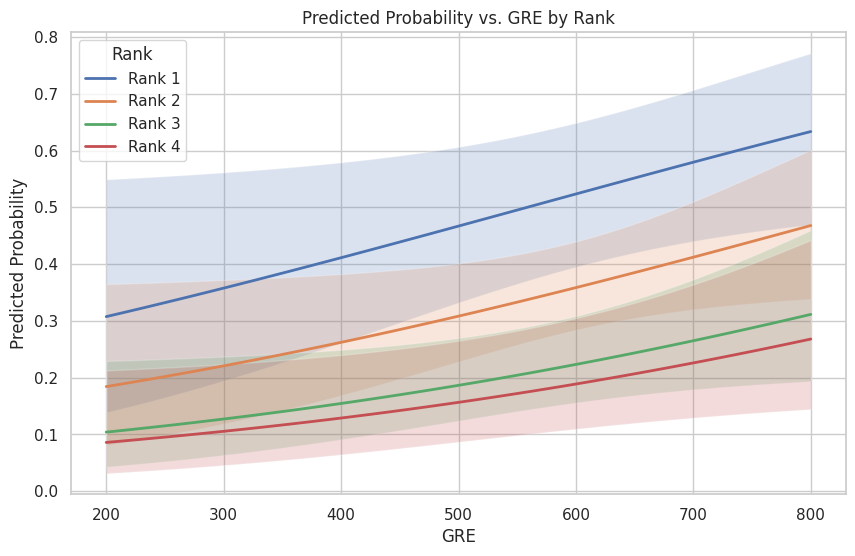

In [129]:
# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot ribbon (confidence interval) and line (predicted probability)
for rank in newdata3['rank'].unique():
    subset = newdata3[newdata3['rank'] == rank]
    plt.fill_between(subset['gre'], subset['ci_lower'], subset['ci_upper'], alpha=0.2)
    plt.plot(subset['gre'], subset['predicted'], label=f'Rank {rank}', linewidth=2)

# Labels and legend
plt.xlabel('GRE')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability vs. GRE by Rank')
plt.legend(title='Rank')
plt.show()

In [130]:
# Calculate deviance for the full model
deviance = -2 * logit_model.llf  # Log-Likelihood of the full model

# Fit the null model (model with only an intercept)
X_null = np.ones((X.shape[0], 1))  # Only intercept, no predictors
null_model = sm.Logit(y, X_null)
null_result = null_model.fit()

# Calculate null deviance
null_deviance = -2 * null_result.llf  # Log-Likelihood of the null model

# Calculate the difference between null deviance and residual deviance
deviance_difference = null_deviance - deviance

print("Null Deviance:", null_deviance, "\n")
print("Model Deviance:", deviance, "\n")
print("Difference between null deviance and model deviance:", deviance_difference)

Optimization terminated successfully.
         Current function value: 0.624971
         Iterations 4
Null Deviance: 499.9765175549154 

Model Deviance: 458.51749247589896 

Difference between null deviance and model deviance: 41.45902507901644


In [131]:
df_difference = logit_model.df_model # df_model: Represents the number of predictors in the model, which is the difference between df.null and df.residual in R.

print("Difference between df.null and df.residual:", df_difference) 

Difference between df.null and df.residual: 5.0


In [132]:
# Calculate the chi-square statistic
chi2_stat = -2 * (logit_model.llnull - logit_model.llf)

# Calculate the degrees of freedom difference
df_difference = logit_model.df_model

# Calculate the p-value
p_value = stats.chi2.sf(chi2_stat, df_difference)

print("P-value for the chi-square test:", p_value)

P-value for the chi-square test: 7.578193995643944e-08


In [133]:
# Get the log-likelihood of the fitted model
log_likelihood = logit_model.llf

# Dynamically get the degrees of freedom (number of parameters in the model)
df = int(logit_model.df_model + 1)  # Adding 1 to account for the intercept

# Display the log-likelihood and degrees of freedom in the desired format
print(f"'log Lik.' {log_likelihood:.0f} (df={df})")

'log Lik.' -229 (df=6)
